<a href="https://colab.research.google.com/github/nish1606/Image-segmentation-Comp-vision/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

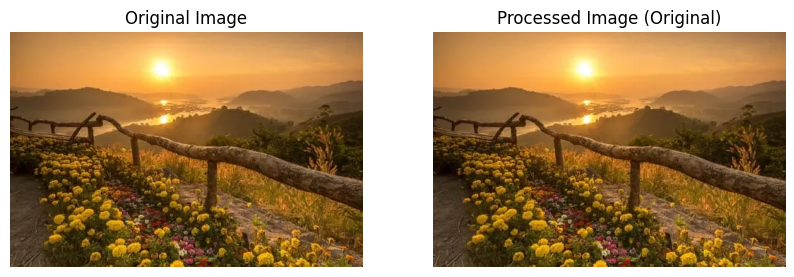

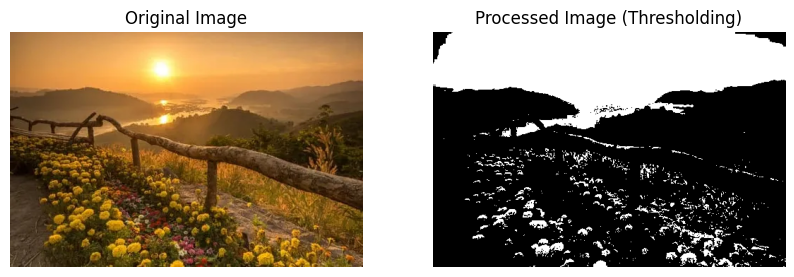

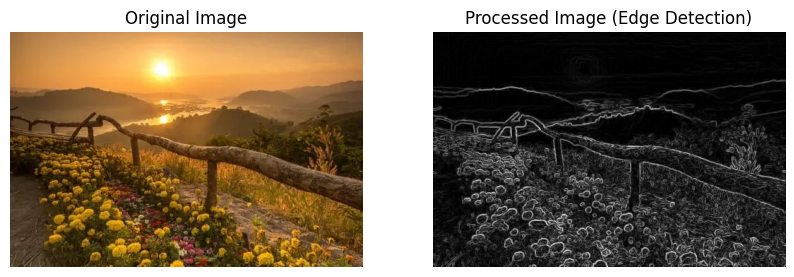

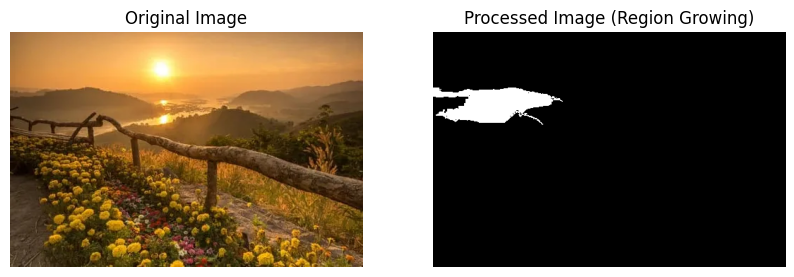

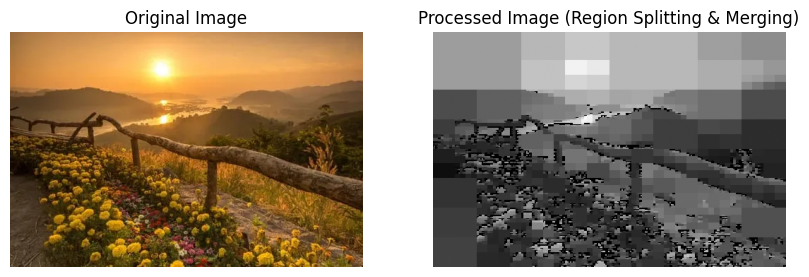

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper functions for image processing
def to_grayscale(image):
    """Converts a BGR image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def basic_global_thresholding(image, threshold_value):
    """Applies basic global thresholding."""
    gray_image = to_grayscale(image)
    _, segmented = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)
    return segmented

def sobel_edge_detection(image):
    """Applies Sobel edge detection."""
    gray_image = to_grayscale(image)
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(sobelx, sobely)
    # Normalize and convert back to 8-bit image
    gradient_magnitude = np.uint8(255 * gradient_magnitude / np.max(gradient_magnitude))
    return gradient_magnitude

def region_growing(image, seed_point, similarity_threshold):
    """Performs region growing segmentation."""
    gray_image = to_grayscale(image)
    height, width = gray_image.shape
    segmented = np.zeros_like(gray_image)
    visited = np.zeros_like(gray_image, dtype=bool)

    if not (0 <= seed_point[0] < width and 0 <= seed_point[1] < height):
        return segmented

    seed_value = gray_image[seed_point[1], seed_point[0]]
    stack = [seed_point]

    while stack:
        x, y = stack.pop()

        if not visited[y, x]:
            visited[y, x] = True
            segmented[y, x] = 255

            # Check neighbors
            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy

                if 0 <= nx < width and 0 <= ny < height and not visited[ny, nx]:
                    neighbor_value = gray_image[ny, nx]
                    if abs(int(neighbor_value) - int(seed_value)) < similarity_threshold:
                        stack.append((nx, ny))
    return segmented

def region_splitting_merging(image, threshold=20):
    """
    Illustrative region splitting and merging using a simplified quadtree.
    Splits if variance is above threshold, merges by filling with average color.
    """
    gray_image = to_grayscale(image)
    height, width = gray_image.shape
    segmented = np.zeros_like(gray_image)

    def split_and_merge(x, y, w, h):
        if w <= 1 or h <= 1:
            return

        region = gray_image[y:y+h, x:x+w]
        if region.size > 0:
            if region.std() > threshold:
                # Split
                split_and_merge(x, y, w // 2, h // 2)
                split_and_merge(x + w // 2, y, w - w // 2, h // 2)
                split_and_merge(x, y + h // 2, w // 2, h - h // 2)
                split_and_merge(x + w // 2, y + h // 2, w - w // 2, h - h // 2)
            else:
                # Merge
                segmented[y:y+h, x:x+w] = np.mean(region)

    split_and_merge(0, 0, width, height)
    return segmented

# --- Main function to process and display all images ---
def process_and_display(image_path):
    # Load the image
    original_image = cv2.imread(image_path)
    if original_image is None:
        print("Error: Could not read image. Please check the file path.")
        return

    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Dictionary of methods and their parameters
    methods = {
        'Original': (original_image_rgb, None),
        'Thresholding': (basic_global_thresholding(original_image, 128), None),
        'Edge Detection': (sobel_edge_detection(original_image), None),
        'Region Growing': (region_growing(original_image, (100, 100), 25), None),
        'Region Splitting & Merging': (region_splitting_merging(original_image, threshold=20), None)
    }

    # Display all processed images using a loop
    for method_name, (image, cmap) in methods.items():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_image_rgb)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Processed Image ({method_name})")
        # Use cmap='gray' for single-channel images
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.axis('off')

        plt.show()

# --- START THE PROJECT ---
# Replace 'image1.webp' with the name of your uploaded image file.
process_and_display('/content/image1.webp')
